In [54]:
import pickle
import numpy as np
from tensorflow import keras
import pandas as pd
import os, datetime
from utils import get_fx_and_metric_data_wo_weekend
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MSE, MAE, MAPE
print('Tensorflow version: {}'.format(tf.__version__))

from sklearn.preprocessing import StandardScaler
import scipy
    
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.4.1


## Hyperparameter

In [55]:
batch_size = 32
seq_len = 256
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

## Data

In [56]:
from utils import get_fx_and_metric_data
df = get_fx_and_metric_data_wo_weekend(dtype=np.float32, directory='../data')
df

,EURUSD BGNE Curncy Bid Open,EURUSD BGNE Curncy Bid Close,EURUSD BGNE Curncy Bid High,EURUSD BGNE Curncy Bid Low,EURUSD BGNE Curncy Bid Number Ticks,EURUSD BGNE Curncy Ask Open,EURUSD BGNE Curncy Ask Close,EURUSD BGNE Curncy Ask High,EURUSD BGNE Curncy Ask Low,EURUSD BGNE Curncy Ask Number Ticks,...,usdjpy___TAS_K,usdjpy___TAS_D,usdjpy___TAS_DS,usdjpy___TAS_DSS,usdjpy___TRENDER_UP,usdjpy___TRENDER_DN,usdjpy___TMAVG,usdjpy___VMAVG,usdjpy___WMAVG,usdjpy___WLPR
Dates,,,,,,,,,,,,,,,,,,,,,
2020-11-01 19:10:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,40.00,56.000000,62.133335,67.244446,104.536598,104.576935,104.551109,104.620003,104.553337,-66.666664
2020-11-01 19:20:00,0.000283,0.000275,0.000197,-0.000507,-0.978125,0.002121,0.001597,0.001631,0.001761,-0.978125,...,40.00,56.000000,62.133335,67.244446,104.536598,104.576935,104.551109,104.620003,104.553337,-66.666664
2020-11-01 19:30:00,0.000172,-0.000069,0.000017,-0.000215,0.380952,0.000043,0.000017,0.000086,0.000137,0.380952,...,40.00,56.000000,62.133335,67.244446,104.536598,104.576935,104.551109,104.620003,104.553337,-66.666664
2020-11-01 19:40:00,0.000060,0.000034,-0.000172,0.000636,3.310345,-0.000274,-0.001157,-0.000009,-0.000926,3.310345,...,40.00,56.000000,62.133335,67.244446,104.536598,104.576935,104.551109,104.620003,104.553337,-66.666664
2020-11-01 19:50:00,-0.000026,0.000026,-0.000026,0.000584,-0.984000,-0.000909,-0.000009,-0.001268,0.000017,-0.984000,...,40.00,56.000000,62.133335,67.244446,104.536598,104.576935,104.552223,104.620003,104.552666,-66.666664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-30 23:10:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,43.75,20.178572,17.983767,17.992258,109.763481,109.747704,109.705559,109.735947,109.706001,-46.153847
2021-07-30 23:20:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,43.75,20.178572,17.983767,17.992258,109.763481,109.747704,109.705559,109.735947,109.706001,-46.153847
2021-07-30 23:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,43.75,20.178572,17.983767,17.992258,109.763481,109.747704,109.705559,109.735947,109.706001,-46.153847


In [57]:
# create a list of our conditions #!!! 
conditions = [
    (df['EURUSD BGNE Curncy Bid Close'] <= -0.00000001),
    (df['EURUSD BGNE Curncy Bid Close'] > -0.00000001) & (df['EURUSD BGNE Curncy Bid Close'] <= 0.00000001),
    (df['EURUSD BGNE Curncy Bid Close'] > 0.00000001)
    ]

# create a list of the values we want to assign for each condition #!!! 
values = [0, 1, 2]

# create a new column and use np.select to assign values to it using our lists as arguments #!!! 
df['strategy'] = np.select(conditions, values)

# display updated DataFrame #!!! 
df.head()

,EURUSD BGNE Curncy Bid Open,EURUSD BGNE Curncy Bid Close,EURUSD BGNE Curncy Bid High,EURUSD BGNE Curncy Bid Low,EURUSD BGNE Curncy Bid Number Ticks,EURUSD BGNE Curncy Ask Open,EURUSD BGNE Curncy Ask Close,EURUSD BGNE Curncy Ask High,EURUSD BGNE Curncy Ask Low,EURUSD BGNE Curncy Ask Number Ticks,...,usdjpy___TAS_D,usdjpy___TAS_DS,usdjpy___TAS_DSS,usdjpy___TRENDER_UP,usdjpy___TRENDER_DN,usdjpy___TMAVG,usdjpy___VMAVG,usdjpy___WMAVG,usdjpy___WLPR,strategy
Dates,,,,,,,,,,,,,,,,,,,,,
2020-11-01 19:10:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,56.0,62.133335,67.244446,104.536598,104.576935,104.551109,104.620003,104.553337,-66.666664,1
2020-11-01 19:20:00,0.000283,0.000275,0.000197,-0.000507,-0.978125,0.002121,0.001597,0.001631,0.001761,-0.978125,...,56.0,62.133335,67.244446,104.536598,104.576935,104.551109,104.620003,104.553337,-66.666664,2
2020-11-01 19:30:00,0.000172,-0.000069,0.000017,-0.000215,0.380952,0.000043,0.000017,0.000086,0.000137,0.380952,...,56.0,62.133335,67.244446,104.536598,104.576935,104.551109,104.620003,104.553337,-66.666664,0
2020-11-01 19:40:00,0.000060,0.000034,-0.000172,0.000636,3.310345,-0.000274,-0.001157,-0.000009,-0.000926,3.310345,...,56.0,62.133335,67.244446,104.536598,104.576935,104.551109,104.620003,104.553337,-66.666664,2
2020-11-01 19:50:00,-0.000026,0.000026,-0.000026,0.000584,-0.984000,-0.000909,-0.000009,-0.001268,0.000017,-0.984000,...,56.0,62.133335,67.244446,104.536598,104.576935,104.552223,104.620003,104.552666,-66.666664,2


In [58]:
target = 'strategy' #!!! 

## Create training, validation and test split

In [59]:
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Convert pandas columns into arrays
train_data = df_train.values
#!!! sc = StandardScaler().fit(train_data)
#!!! sc_target = StandardScaler().fit(df_train.loc[:, target].values.reshape(-1, 1))
#!!! train_data = sc.transform(train_data)
train_data_dates = df_train.index.values  

sc = train_data   #!!! 
sc_target = train_data   #!!! 

#!!! val_data = sc.transform(df_val.values)
val_data = df_val.values #!!! 
val_data_dates = df_val.index.values  

#!!! test_data = sc.transform(df_test.values)
test_data = df_test.values #!!! 
test_data_dates = df_test.index.values 

print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (23210, 1232)
Validation data shape: (2901, 1232)
Test data shape: (2901, 1232)


,EURUSD BGNE Curncy Bid Open,EURUSD BGNE Curncy Bid Close,EURUSD BGNE Curncy Bid High,EURUSD BGNE Curncy Bid Low,EURUSD BGNE Curncy Bid Number Ticks,EURUSD BGNE Curncy Ask Open,EURUSD BGNE Curncy Ask Close,EURUSD BGNE Curncy Ask High,EURUSD BGNE Curncy Ask Low,EURUSD BGNE Curncy Ask Number Ticks,...,usdjpy___TAS_D,usdjpy___TAS_DS,usdjpy___TAS_DSS,usdjpy___TRENDER_UP,usdjpy___TRENDER_DN,usdjpy___TMAVG,usdjpy___VMAVG,usdjpy___WMAVG,usdjpy___WLPR,strategy
Dates,,,,,,,,,,,,,,,,,,,,,
2020-11-01 19:10:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,56.0,62.133335,67.244446,104.536598,104.576935,104.551109,104.620003,104.553337,-66.666664,1
2020-11-01 19:20:00,0.000283,0.000275,0.000197,-0.000507,-0.978125,0.002121,0.001597,0.001631,0.001761,-0.978125,...,56.0,62.133335,67.244446,104.536598,104.576935,104.551109,104.620003,104.553337,-66.666664,2
2020-11-01 19:30:00,0.000172,-0.000069,0.000017,-0.000215,0.380952,0.000043,0.000017,0.000086,0.000137,0.380952,...,56.0,62.133335,67.244446,104.536598,104.576935,104.551109,104.620003,104.553337,-66.666664,0
2020-11-01 19:40:00,0.000060,0.000034,-0.000172,0.000636,3.310345,-0.000274,-0.001157,-0.000009,-0.000926,3.310345,...,56.0,62.133335,67.244446,104.536598,104.576935,104.551109,104.620003,104.553337,-66.666664,2
2020-11-01 19:50:00,-0.000026,0.000026,-0.000026,0.000584,-0.984000,-0.000909,-0.000009,-0.001268,0.000017,-0.984000,...,56.0,62.133335,67.244446,104.536598,104.576935,104.552223,104.620003,104.552666,-66.666664,2


## Plot daily changes of close prices and volatility

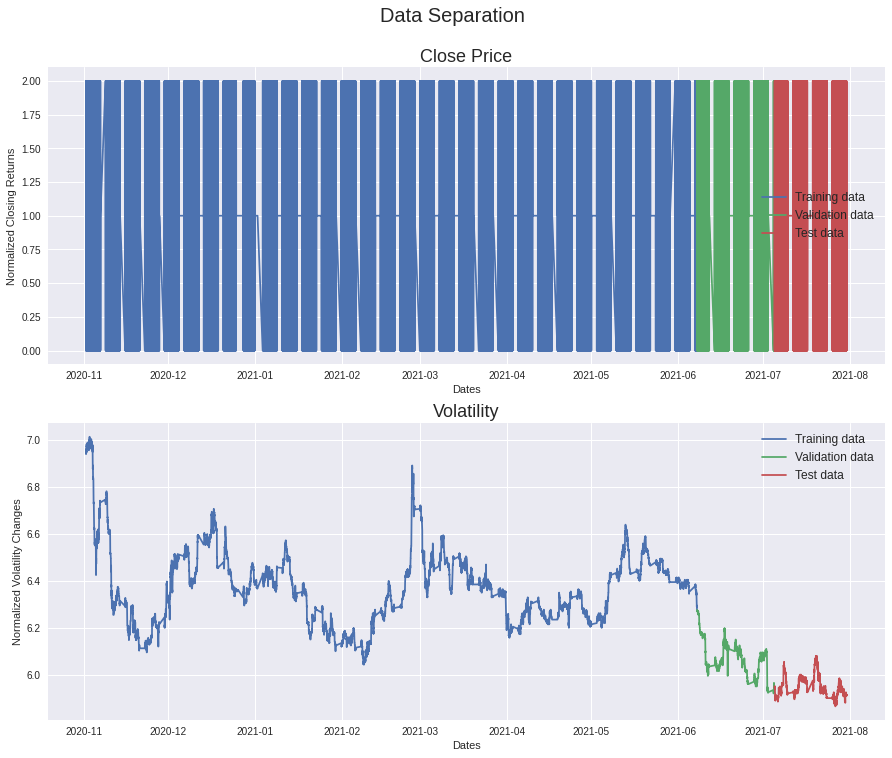

In [60]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(train_data_dates, df_train[target], label='Training data')
ax1.plot(val_data_dates, df_val[target], label='Validation data')
ax1.plot(test_data_dates, df_test[target], label='Test data')
ax1.set_xlabel('Dates')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(train_data_dates, df_train['EURUSDV1Y Curncy Trade Open'], label='Training data') 
ax2.plot(val_data_dates, df_val['EURUSDV1Y Curncy Trade Open'], label='Validation data') 
ax2.plot(test_data_dates, df_test['EURUSDV1Y Curncy Trade Open'], label='Test data') 
ax2.set_xlabel('Dates')
ax2.set_ylabel('Normalized Volatility Changes')
ax2.set_title("Volatility", fontsize=18)
ax2.legend(loc="best", fontsize=12)

## Create chunks of training, validation and test data

In [61]:
target_id = list(df_train.columns).index(target)
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
    X_train.append(train_data[i-seq_len:i])
    y_train.append(train_data[:, target_id][i])
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, target_id][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, target_id][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (22954, 256, 1232) (22954,)
Validation set shape (2645, 256, 1232) (2645,)
Testing set shape (2645, 256, 1232) (2645,)


## TimeVector

In [62]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config
  

## Transformer

In [63]:
class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

    def build(self, input_shape):
        self.query = Dense(self.d_k, 
                           input_shape=input_shape, 
                           kernel_initializer='glorot_uniform', 
                           bias_initializer='glorot_uniform')

        self.key = Dense(self.d_k, 
                         input_shape=input_shape, 
                         kernel_initializer='glorot_uniform', 
                         bias_initializer='glorot_uniform')

        self.value = Dense(self.d_v, 
                           input_shape=input_shape, 
                           kernel_initializer='glorot_uniform', 
                           bias_initializer='glorot_uniform')

    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)

        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out    

#############################################################################

class MultiAttention(Layer):
    def __init__(self, d_k, d_v, n_heads):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.attn_heads = list()

    def build(self, input_shape):
        for n in range(self.n_heads):
            self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  

        # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
        self.linear = Dense(input_shape[0][-1], 
                            input_shape=input_shape, 
                            kernel_initializer='glorot_uniform', 
                            bias_initializer='glorot_uniform')

    def call(self, inputs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        concat_attn = tf.concat(attn, axis=-1)
        multi_linear = self.linear(concat_attn)
        return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.attn_heads = list()
        self.dropout_rate = dropout

    def build(self, input_shape):
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        self.attn_dropout = Dropout(self.dropout_rate)
        self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

        self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
        # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
        self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
        self.ff_dropout = Dropout(self.dropout_rate)
        self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer 

    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'d_k': self.d_k,
                       'd_v': self.d_v,
                       'n_heads': self.n_heads,
                       'ff_dim': self.ff_dim,
                       'attn_heads': self.attn_heads,
                       'dropout_rate': self.dropout_rate})
        return config          

## Model

In [ ]:
def create_model(input_shape):
    '''Initialize time and transformer layers'''
    time_embedding = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    '''Construct model'''
    in_seq = Input(shape=(seq_len, input_shape))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    #   x = Concatenate(axis=-1)([Dense(128)(in_seq), x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    # x = GlobalAveragePooling1D(data_format='channels_first')(x)
    # x = Dense(256, activation='relu')(x)
    x = Flatten()(x)    
    x = Dropout(0.01)(x)
    x = Dense(64, activation='linear')(x)
    out = Dense(3, activation='linear')(x)

    model = Model(inputs=in_seq, outputs=out)
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#!!!     model.compile(loss='mse', optimizer=opt, metrics=['mae', 'mape                                               
    return model


model = create_model(df.shape[1])
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('../content/Transformer+TimeEmbeddingClassification{epoch:04}.hdf5', 
                                               monitor='val_loss', 
                                               save_best_only=True, verbose=1
                                             )

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=8,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)


if True: 
    history = model.fit(X_train, y_train,
                        batch_size=batch_size, 
                        epochs=70,
                        callbacks=[callback],
                        validation_data=(X_val, y_val))  
    with open('../content/historyClassification.pkl', 'wb') as f:
        pickle.dump(history.history, f)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1232)]  0                                            
__________________________________________________________________________________________________
time2_vector_3 (Time2Vector)    (None, 256, 2)       1024        input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 1234)    0           input_1[0][0]                    
                                                                 time2_vector_3[0][0]             
__________________________________________________________________________________________________
transformer_encoder_9 (Transfor (None, 256, 1234)    15812076    concatenate[0][0]            

718/718 [==============================] - 2317s 3s/step - loss: 0.8357 - accuracy: 0.4777 - val_loss: 0.8167 - val_accuracy: 0.4752

Epoch 00023: val_loss did not improve from 0.80689
Epoch 24/70
718/718 [==============================] - 2325s 3s/step - loss: 0.8401 - accuracy: 0.4784 - val_loss: 0.8071 - val_accuracy: 0.4752

Epoch 00024: val_loss did not improve from 0.80689
Epoch 25/70
718/718 [==============================] - 2320s 3s/step - loss: 0.8385 - accuracy: 0.4801 - val_loss: 0.8084 - val_accuracy: 0.4949

Epoch 00025: val_loss did not improve from 0.80689
Epoch 26/70
718/718 [==============================] - 2309s 3s/step - loss: 0.8371 - accuracy: 0.4746 - val_loss: 0.8080 - val_accuracy: 0.4752

Epoch 00026: val_loss did not improve from 0.80689
Epoch 27/70
718/718 [==============================] - 2350s 3s/step - loss: 0.8377 - accuracy: 0.4786 - val_loss: 0.8069 - val_accuracy: 0.4949

Epoch 00027: val_loss did not improve from 0.80689
Epoch 28/70
718/718 [======

In [ ]:
model_last = sorted([i for i in os.listdir('../content') if 'hdf5' in i and 'Transformer+TimeEmbeddingClassification' in i])[-1]

In [ ]:
model = tf.keras.models.load_model(
    os.path.join('../content', model_last),
    custom_objects={
        'Time2Vector': Time2Vector,
        'SingleAttention': SingleAttention,
        'MultiAttention': MultiAttention,
        'TransformerEncoder': TransformerEncoder
    }
)
with open('../content/historyClassification.pkl', 'rb') as f:
    history = pickle.load(f)

In [ ]:
###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - accuracy: {:.4f}'.format(train_eval[0]))
print('Validation Data - accuracy: {:.4f}'.format(val_eval[0]))
print('Test Data - accuracy: {:.4f}'.format(test_eval[0]))

### Training error

In [ ]:
#!!! def mde(y_true, y_pred):
#!!!     return 1 - np.equal(y_true[1:] - y_true[:-1] >= 0, y_pred[1:] - y_true[:-1] >= 0).mean()

In [ ]:
#!!! y = sc_target.inverse_transform(y_train.reshape(-1, 1))
#!!! y_pred = sc_target.inverse_transform(train_pred)
#!!! print(f'mse: {MSE(y.flatten(), y_pred.flatten()).numpy()}')
#!!! print(f'mae: {MAE(y.flatten(), y_pred.flatten()).numpy()}')
#!!! print(f'mape: {MAPE(y.flatten(), y_pred.flatten()).numpy()}')
#!!! print(f'mde: {mde(y.flatten(), y_pred.flatten())}')

### Validation Error

In [ ]:
#!!! y = sc_target.inverse_transform(y_val.reshape(-1, 1))
#!!! y_pred = sc_target.inverse_transform(val_pred)
#!!! print(f'mse: {MSE(y.flatten(), y_pred.flatten()).numpy()}')
#!!! print(f'mae: {MAE(y.flatten(), y_pred.flatten()).numpy()}')
#!!! print(f'mape: {MAPE(y.flatten(), y_pred.flatten()).numpy()}')
#!!! print(f'mde: {mde(y.flatten(), y_pred.flatten())}')

### Test Error

In [ ]:
#!!! y = sc_target.inverse_transform(y_test.reshape(-1, 1))
#!!! y_pred = sc_target.inverse_transform(test_pred)
#!!! print(f'mse: {MSE(y.flatten(), y_pred.flatten()).numpy()}')
#!!! print(f'mae: {MAE(y.flatten(), y_pred.flatten()).numpy()}')
#!!! print(f'mape: {MAPE(y.flatten(), y_pred.flatten()).numpy()}')
#!!! print(f'mde: {mde(y.flatten(), y_pred.flatten())}')

## Display Results

In [ ]:
###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data_dates, train_data[:, 1], label='EURUSD Closing Returns')
ax11.plot(train_data_dates[seq_len:], train_pred, linewidth=3, label='Predicted EURUSD Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Dates')
ax11.set_ylabel('EURUSD Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data_dates, val_data[:, 1], label='EURUSD Closing Returns')
ax21.plot(val_data_dates[seq_len:], val_pred, linewidth=3, label='Predicted EURUSD Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Dates')
ax21.set_ylabel('EURUSD Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data_dates, test_data[:, 1], label='EURUSD Closing Returns')
ax31.plot(test_data_dates[seq_len:], test_pred, linewidth=3, label='Predicted EURUSD Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Dates')
ax31.set_ylabel('EURUSD Closing Returns')
ax31.legend(loc="best", fontsize=12)

## Model metrics

In [ ]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history['accuracy'], label='Training loss (accuracy)')
ax1.plot(history['val_accuracy'], label='Test loss (accuracy)')
ax1.set_title("Model accuracy", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (accuracy)')
ax1.legend(loc="best", fontsize=12)

## Model architecture overview

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="EURUSD_Transformer+TimeEmbedding1.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)

In [ ]:
#Berechnung Return, Standardabweichung & Sharpe Ratio: Code/Skript von Marius für ARIMA übernehmen